In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Feature Engineering
# Merge customer and transaction data
merged_data = pd.merge(transactions, customers, on='CustomerID')

# Create customer profiles
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'nunique',
    'Region': 'first',
    'SignupDate': 'first'
}).reset_index()

In [12]:

# Calculate average order value
customer_profiles['AvgOrderValue'] = customer_profiles['TotalValue'] / customer_profiles['Quantity']

# Convert SignupDate to days since signup
customer_profiles['DaysSinceSignup'] = (datetime.now() - pd.to_datetime(customer_profiles['SignupDate'])).dt.days

# One-hot encode Region
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'])

In [13]:
#  Feature Engineering
# Add Recency, Frequency, Monetary (RFM) features
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
recency = merged_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (datetime.now() - recency['TransactionDate']).dt.days
customer_profiles = pd.merge(customer_profiles, recency[['CustomerID', 'Recency']], on='CustomerID')



In [14]:
#  Normalize Features
numerical_features = ['TotalValue', 'Quantity', 'TransactionID', 'AvgOrderValue', 'DaysSinceSignup', 'Recency']
scaler = StandardScaler()
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])



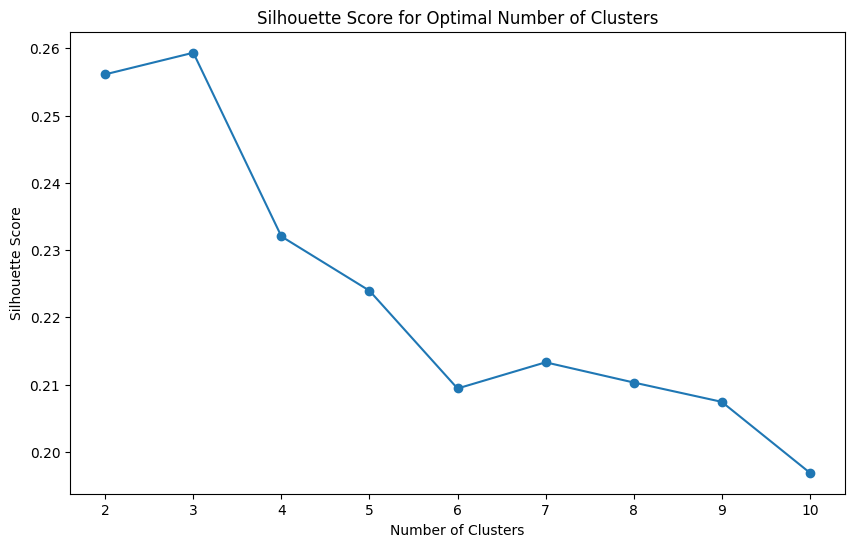

In [15]:
#  Determine Optimal Number of Clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profiles[numerical_features])
    score = silhouette_score(customer_profiles[numerical_features], kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [16]:
#  Perform Clustering with Optimal k
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[numerical_features])

In [17]:
#  Evaluate Clusters
db_index = davies_bouldin_score(customer_profiles[numerical_features], customer_profiles['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

silhouette_avg = silhouette_score(customer_profiles[numerical_features], customer_profiles['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 1.2673606722889479
Silhouette Score: 0.2593338278033991


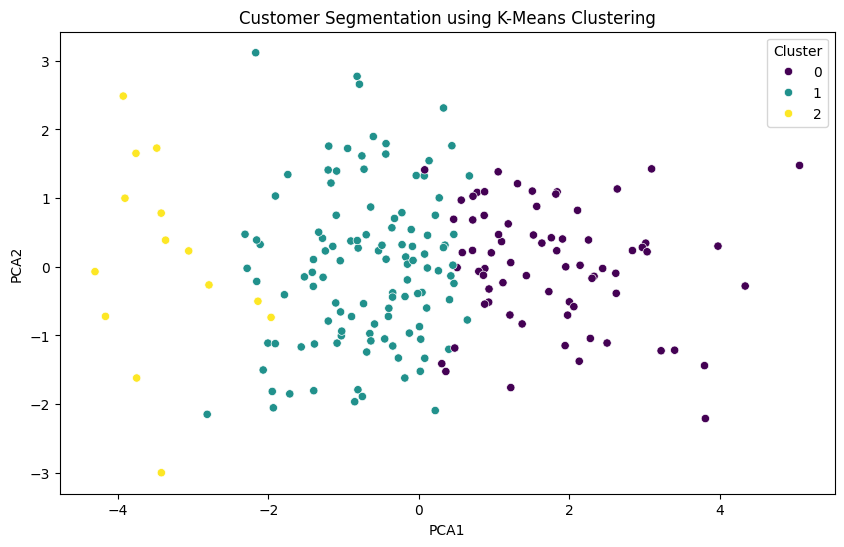

In [18]:
#  Visualize Clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_profiles[numerical_features])
customer_profiles['PCA1'] = pca_result[:, 0]
customer_profiles['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_profiles, palette='viridis')
plt.title('Customer Segmentation using K-Means Clustering')
plt.show()